# **Predictive Crime Mapping with a spatio-temporal kernel density estimation approach**

## **Case of study: Dallas City**

*Institute of Mathematical and Computational Engineering*

*School of Engineering*

*Pontifical Catholic University of Chile*

**Authors:** Christian Carstens, Mauro Mendoza, Francisco Tobar

**Date:** 2019-04-11

`Python version: 3.7`

### **DB Request**

In [1]:
import pandas as pd
from sodapy import Socrata

import credentials as cre

In [225]:
with Socrata(cre.socrata_domain,
             cre.API_KEY_S,
             username=cre.USERNAME_S,
             password=cre.PASSWORD_S) as client:
    query = """
select
    incidentnum,
    geocoded_column,
    date1,
    time1,
    x_coordinate,
    y_cordinate
where
    geocoded_column is not null
    and date1 is not null
    and time1 is not null
    and x_coordinate is not null
    and y_cordinate is not null
limit
    10000
""" # 530000 max. 11/04

    results = client.get(cre.socrata_dataset_identifier, query=query, content_type='json')
    df = pd.DataFrame.from_records(results)

In [208]:
# ejecutar esto para la parte post-mapa arcgis

df_hm = df[['x_coordinate', 'y_cordinate']]
df_hm.rename(columns={'x_coordinate':'x', 'y_cordinate':'y'}, inplace=True)
df_hm['x'] = df_hm['x'].apply(lambda x: float(x))
df_hm['y'] = df_hm['y'].apply(lambda x: float(x))

/Users/msmendozaelguera/Library/Mobile Documents/com~apple~CloudDocs/2019-1/iPre/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/msmendozaelguera/Library/Mobile Documents/com~apple~CloudDocs/2019-1/iPre/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### **DB Cleaning & Formatting**

#### Cleaning

In [111]:
from datetime import date, time, datetime
from time import strftime

In [112]:
# 'date1' column cleaning: deleting 'T00:00:00.000'
# df["date1"] = df['date1'].apply(lambda x: date(*(int(i) for i in x.split('T')[0].split('-'))))

df["date1"] = df['date1'].apply(lambda x: '/'.join([str(int(i)) for i in x.split('T')[0].split('-')[::-1]]))
df["time1"] = df['time1'].apply(lambda x: datetime.strptime(x, "%H:%M").strftime("%I:%M %p"))

df['datetime'] = df["date1"] + ' ' + df["time1"]

# 'incidentnum' column cleaning: deleting '20XX'
df["incidentnum"] = df['incidentnum'].apply(lambda x: x.split('-')[0])

# Modificar la columna 'geocoded_column': Dividirla en dos columnas -> latitude, longitude

# dict to list: [latitude, longitude]
df['geocoded_column'] = df['geocoded_column'].apply(lambda x: x['coordinates'])

# Column creation: latitude & longitude
df['longitude'] = df['geocoded_column'].apply(lambda x: x[0])
df['latitude'] = df['geocoded_column'].apply(lambda x: x[1])

# Deletion the old column 'geocoded_column'
del df['geocoded_column']
del df["date1"]
del df["time1"]

#### Formatting

In [113]:
# Cambio de nombre en las columnas
df.rename(columns={'incidentnum':'incident_id'}, inplace=True)

# Cambio de las posiciones de las columnas
df = df[['incident_id', 'datetime',  'longitude', 'latitude']]

# Sort of the 'incident_id' column
df.sort_values(by=['incident_id'], inplace=True)

# Reset the old index
df.reset_index(drop=True, inplace=True)
df.index = df.index + 1

/Users/msmendozaelguera/Library/Mobile Documents/com~apple~CloudDocs/2019-1/iPre/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [34]:
# En caso de que queramos exportar la base a .csv
# df.to_csv('dallas_db.csv', index=False)

### Dallas Map

Cargamos los elementos necesarios para la visualización del mapa.

In [35]:
from arcgis import GIS, geocoding, features, geometry
from arcgis.gis import GIS
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.mapping import renderer

from credentials import arcgis_domain, USERNAME_A, PASSWORD_A

In [36]:
gis = GIS(arcgis_domain, USERNAME_A, PASSWORD_A)

In [42]:
_map = gis.map('Dallas', zoomlevel=11, mode="3D")
#_map.basemap = "dark-gray-vector"

sdf = df.spatial
incidents = gis.content.import_data(df, title="Dallas Incidents")

_map.add_layer(incidents)

In [43]:
_map

MapView(layout=Layout(height='400px', width='100%'), mode='3D', zoom=11.0)

In [187]:
import pandas as pd

import numpy as np
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import kde

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

In [142]:
dallas = gpd.read_file('shp/STREETS.shp')
crs = dallas.crs

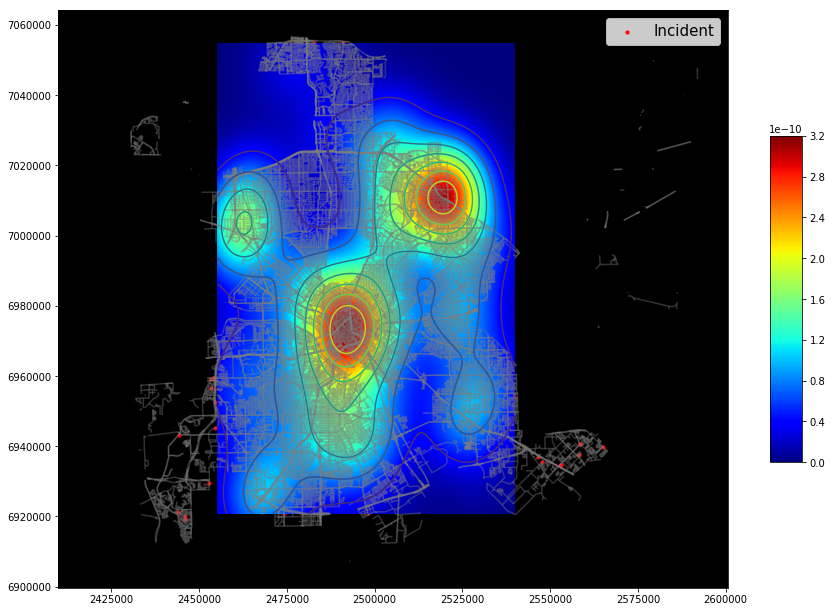

In [230]:
geometry = [Point(xy) for xy in zip(df_hm['x'], df_hm['y'])]
geo_df = gpd.GeoDataFrame(df_hm,
                         crs = crs,
                         geometry = geometry)

fig, ax = plt.subplots(figsize = (15, 15))
ax.set_facecolor('xkcd:black')

dallas.plot(ax = ax, alpha = .4, color="gray")
geo_df.plot(ax = ax, markersize = 10, color = 'red', marker = 'o', label = 'Incident')
plt.legend(prop={'size': 15})

nbins = 1000
data = np.array(df_hm[['x','y']])

k = kde.gaussian_kde(data.T)
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
cs = plt.contour(xi, yi, zi.reshape(xi.shape), cmap = 'jet')

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=cs.cvalues.min(), vmax=cs.cvalues.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap = cs.cmap)
sm.set_array([])
fig.colorbar(sm, ticks=cs.levels, shrink=.4, aspect=10)

# Se comenta lo de abajo para ver solo los contornos.
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap='jet')
plt.contour(xi, yi, zi.reshape(xi.shape))